### `list_attr_celeba` Dataset
A popular component of computer vision and deep learning revolves around identifying faces for various applications from logging into your phone with your face or searching through surveillance images for a particular suspect. This dataset is great for training and testing models for face detection, particularly for recognising facial attributes such as finding people with brown hair, are smiling, or wearing glasses. Images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong (specific reference in Acknowledgment section).



- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image

You can obtain the dataset from https://www.kaggle.com/jessicali9530/celeba-dataset

In [48]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import keras
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, load_img, image
from keras.utils import to_categorical
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization

In [7]:
mypath='/Users/gceran/Google Drive/Courses/MagniMind/Mentorship Program/DL-MentorProgram/DL_Mentor_Week2/Class 1'
print(os.listdir(mypath))

df=pd.read_csv(mypath+'/list_attr_celeba.csv')

df.head()
df.columns.values

['Facial_keypoints.ipynb', 'GenderIDex.JPG', 'Transfer_learning.ipynb', 'img_align_celeba.zip', 'Week2-Class1-St.zip', 'weights.best.hdf5', '.DS_Store', 'Week2-Class1-St', 'Icon\r', 'test', 'weights-improvement-17-0.66.hdf5', 'weights-improvement-76-0.74.hdf5', 'weights-improvement-71-0.73.hdf5', 'input', 'small_c_d', 'weights-improvement-43-0.69.hdf5', 'weights-improvement-109-0.76.hdf5', 'celeb_small', 'weights-improvement-51-0.69.hdf5', 'weights-improvement-28-0.67.hdf5', 'weights-improvement-140-0.76.hdf5', 'Celeb_sets', 'P1_Facial_Keypoints', 'Gender_ID_VGG16.py', 'weights-improvement-57-0.71.hdf5', 'get-start-image-classification.ipynb', 'weights-improvement-79-0.75.hdf5', 'cats_dogs', 'list_attr_celeba.csv', 'test1.zip', 'train', 'weights-improvement-01-0.66.hdf5', 'model.h5', 'vgg16_1.h5', 'Gender_ID_VGG16_v02.py', '.ipynb_checkpoints', 'weights-improvement-41-0.69.hdf5', 'Gender_ID_Inception.py', 'diabetes.csv', 'Week2-Class1-Inst', 'weights-improvement-29-0.68.hdf5', 'weights

array(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
       'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'], dtype=object)

In [10]:
# get image labels for males
#male=df[df['Male']==1][0:20000][['image_id', 'Male']]

#female=df[df['Male']==-1][0:20000][['image_id','Male']]

filenames = os.listdir(os.path.join(mypath, 'celeb_small'))
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'man':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [11]:
df.head()

filename  category
0  female.026413.jpg         0
1  female.022675.jpg         0
2     man.033406.jpg         1
3     man.033360.jpg         1
4  female.020704.jpg         0

In [13]:
df['category'].value_counts()

0    1909
1    1892
Name: category, dtype: int64

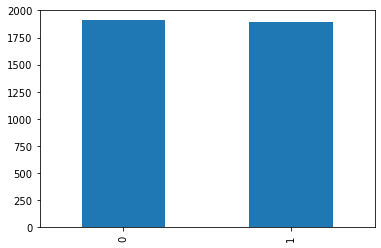

In [12]:
df['category'].value_counts().plot.bar()

From our data we have 1909 male and 1892 female

#### See sample image

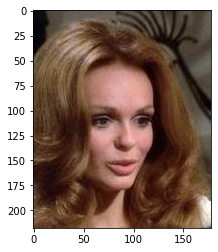

In [16]:
sample = random.choice(filenames)
pathimage=os.path.join(mypath, 'celeb_small/')
image = load_img(pathimage+sample)
plt.imshow(image)

### 4. Build Model

In [43]:
######## Modeling ################################


num_classes=2

vgg_model = VGG16(include_top=False, pooling='avg', weights='imagenet',input_shape=(178, 218, 3))
print(vgg_model.summary())


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 178, 218, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 178, 218, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 178, 218, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 89, 109, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 89, 109, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 89, 109, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 54, 128)       0     

In [69]:
# Freeze the layers except the last x number of layers
for layer in vgg_model.layers[:-2]:
    layer.trainable = False

In [70]:
# Check the trainable status of the individual layers
for layer in vgg_model.layers:
    print(layer, layer.trainable)
    

<keras.engine.input_layer.InputLayer object at 0x1ada022ba8> False
<keras.layers.convolutional.Conv2D object at 0x1ada022c18> False
<keras.layers.convolutional.Conv2D object at 0x1ada022ef0> False
<keras.layers.pooling.MaxPooling2D object at 0x1afb192710> False
<keras.layers.convolutional.Conv2D object at 0x1afb192518> False
<keras.layers.convolutional.Conv2D object at 0x1afb1ab860> False
<keras.layers.pooling.MaxPooling2D object at 0x1afb1be978> False
<keras.layers.convolutional.Conv2D object at 0x1afb1be550> False
<keras.layers.convolutional.Conv2D object at 0x1afb1cb860> False
<keras.layers.convolutional.Conv2D object at 0x1afb1dfa20> False
<keras.layers.pooling.MaxPooling2D object at 0x1afb1f6908> False
<keras.layers.convolutional.Conv2D object at 0x1afb1f64e0> False
<keras.layers.convolutional.Conv2D object at 0x1afb1fc7f0> False
<keras.layers.convolutional.Conv2D object at 0x1afb2129b0> False
<keras.layers.pooling.MaxPooling2D object at 0x1afb22f898> False
<keras.layers.convoluti

In [71]:
# Create the model
model1 = keras.Sequential()


# Add the vgg convolutional base model
for layer in vgg_model.layers:
    model1.add(layer)
 
 # Add new layers
model1.add(Dense(128, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(num_classes, activation='softmax'))

model1.summary()

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 178, 218, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 178, 218, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 89, 109, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 89, 109, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 89, 109, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 54, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 44, 54, 256)      

In [72]:
# use early stopping to optimally terminate training through callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [74]:
model1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 178, 218, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 178, 218, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 89, 109, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 89, 109, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 89, 109, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 54, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 44, 54, 256)      

In [75]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


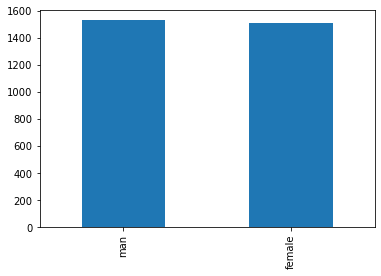

In [54]:
# save best model automatically
import h5py
mc= ModelCheckpoint(mypath+'best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
cb_list=[es,mc]

df["category"] = df["category"].replace({0: 'female', 1: 'man'}) 
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
train_df['category'].value_counts().plot.bar()


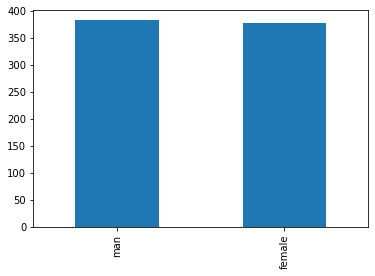

In [55]:
validate_df['category'].value_counts().plot.bar()
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=20

In [56]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


In [60]:
train_generator = data_generator.flow_from_dataframe(
        train_df,
        pathimage,
        x_col='filename',
        y_col='category',
        target_size=(178, 218),
        batch_size=12,
        class_mode='categorical')

Found 3040 validated image filenames belonging to 2 classes.


In [61]:
validation_generator = data_generator.flow_from_dataframe(
        validate_df,
        pathimage,
        x_col='filename',
        y_col='category',
        target_size=(178, 218),
        batch_size=12,
        class_mode='categorical')

Found 761 validated image filenames belonging to 2 classes.


In [63]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=12


In [ ]:
model1.fit_generator(
        train_generator,
        epochs=2,
        validation_data=validation_generator,
        validation_steps=total_validate//batch_size,
        steps_per_epoch=total_train//batch_size,
        callbacks=cb_list)

Epoch 1/2
253/253 [==============================] - 1176s 5s/step - loss: 0.3399 - accuracy: 0.8633 - val_loss: 0.1259 - val_accuracy: 0.8915

Epoch 00001: val_loss improved from inf to 0.12585, saving model to /Users/gceran/Google Drive/Courses/MagniMind/Mentorship Program/DL-MentorProgram/DL_Mentor_Week2/Class 1best_model.h5
Epoch 2/2
252/253 [============================>.] - ETA: 8s - loss: 0.2229 - accuracy: 0.9158 

In [ ]:
# load a saved model
from keras.models import load_model
saved_model = load_model('best_model.h5')